SqueezeNet trained on ImageNet https://medium.freecodecamp.org/recognizing-traffic-lights-with-deep-learning-23dae23287cc

## Import Dependencies

In [1]:
from keras import applications,optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 

from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, warnings
from keras.layers import Dropout, Flatten, Dense

from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D

from keras_squeezenet import SqueezeNet

Using TensorFlow backend.


In [2]:
import shutil,os
import pandas as pd
import yaml
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Download dataset from S3

In [51]:
# TODO...

## Prepare dataset for training

In [3]:
annontated_data_path = 'data/sim-data-capture/'
with open(annontated_data_path + 'sim_data_large.yaml', 'r') as f:
    df = pd.io.json.json_normalize(yaml.load(f))

def parse_values(val):

    if len(val) == 0:
        return 'noColor'
    else:
        return (val[0]['class'])
    
df['color'] = df.annotations.map(parse_values)
df.filename = df.filename.str.replace('sim_data_capture/','sim-data-capture/',)

In [4]:
try:
    shutil.rmtree('data/train/')
    shutil.rmtree('data/valid/')
except:
    pass

os.mkdir('data/train/')
os.mkdir('data/valid/')

os.mkdir('data/train/Green')
os.mkdir('data/train/Red')
os.mkdir('data/train/Yellow')
os.mkdir('data/train/noColor')

os.mkdir('data/valid/Green')
os.mkdir('data/valid/Red')
os.mkdir('data/valid/Yellow')
os.mkdir('data/valid/noColor')

In [ ]:
for color in ['Green','Yellow','Red','noColor']:
    
    files = df[df.color == color].filename.values.tolist()
    if color == 'Red':
        np.random.shuffle(files)
        files = files[:50]
    print(color, len(files))
    for filename in files:
        if np.random.rand(1)[0] < 0.8:
            shutil.copy(src='data/' + filename, dst='data/train/'+color+'/')
        else:    
            shutil.copy(src='data/' + filename, dst='data/valid/'+color+'/')

## Prepare for training

In [6]:
img_width, img_height = 227, 227
train_data_dir = "data/train"
validation_data_dir = "data/valid"
nb_train_samples = 208
nb_validation_samples = 48 
batch_size = 16
epochs = 100

In [7]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [8]:
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [9]:
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

Found 162 images belonging to 4 classes.


In [10]:
validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
#batch_size = batch_size*0.40, 
class_mode = "categorical")

Found 34 images belonging to 4 classes.


## Replace output layer with our own layers for transfer learning

In [11]:
classes = 4

model = SqueezeNet(include_top=False, pooling=None , input_shape=(227,227,3))
for layer in model.layers:
    #print(layer.trainable, end=',')
    layer.trainable = False

x = model.output


x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(512, activation="relu")(x)
x = Dense(classes, activation="softmax")(x)



model_final = Model(inputs = model.input, outputs = x)
#optimizers.SGD(lr=0.00005) also gives decent results
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(lr=0.00001), metrics=["accuracy"])

3039232/3032184 [==============================] - 3s 1us/step


## Train model

In [12]:
model_final.fit_generator(
train_generator,
steps_per_epoch = 25,# nb_train_samples/batch_size,
epochs = epochs,
validation_data = validation_generator,
validation_steps = nb_validation_samples/batch_size)

Epoch 1/100
25/25 [==============================] - 45s 2s/step - loss: 3.4553 - acc: 0.2933 - val_loss: 0.6719 - val_acc: 0.7273
Epoch 2/100
25/25 [==============================] - 41s 2s/step - loss: 2.0356 - acc: 0.4689 - val_loss: 0.7154 - val_acc: 0.7576
Epoch 3/100
25/25 [==============================] - 42s 2s/step - loss: 1.5651 - acc: 0.5226 - val_loss: 0.4550 - val_acc: 0.8182
Epoch 4/100
25/25 [==============================] - 43s 2s/step - loss: 1.1053 - acc: 0.6203 - val_loss: 0.4163 - val_acc: 0.9091
Epoch 5/100
25/25 [==============================] - 42s 2s/step - loss: 1.1461 - acc: 0.6229 - val_loss: 0.8412 - val_acc: 0.6212
Epoch 6/100
25/25 [==============================] - 43s 2s/step - loss: 0.7260 - acc: 0.7367 - val_loss: 0.5294 - val_acc: 0.7576
Epoch 7/100
25/25 [==============================] - 55s 2s/step - loss: 0.7565 - acc: 0.7521 - val_loss: 0.3971 - val_acc: 0.8485
Epoch 8/100
25/25 [==============================] - 45s 2s/step - loss: 0.5364 - a

25/25 [==============================] - 39s 2s/step - loss: 0.1192 - acc: 0.9574 - val_loss: 0.2396 - val_acc: 0.8939
Epoch 64/100
25/25 [==============================] - 39s 2s/step - loss: 0.1704 - acc: 0.9329 - val_loss: 0.2704 - val_acc: 0.8788
Epoch 65/100
25/25 [==============================] - 42s 2s/step - loss: 0.1506 - acc: 0.9474 - val_loss: 0.1940 - val_acc: 0.8788
Epoch 66/100
25/25 [==============================] - 40s 2s/step - loss: 0.1597 - acc: 0.9473 - val_loss: 0.2129 - val_acc: 0.8788
Epoch 67/100
25/25 [==============================] - 50s 2s/step - loss: 0.1453 - acc: 0.9573 - val_loss: 0.1862 - val_acc: 0.9394
Epoch 68/100
25/25 [==============================] - 40s 2s/step - loss: 0.1287 - acc: 0.9549 - val_loss: 0.1465 - val_acc: 0.9242
Epoch 69/100
25/25 [==============================] - 43s 2s/step - loss: 0.1653 - acc: 0.9306 - val_loss: 0.1508 - val_acc: 0.9394
Epoch 70/100
25/25 [==============================] - 43s 2s/step - loss: 0.2602 - acc: 0

## Save Model

In [50]:
# serialize model to JSON
model_json = model.to_json()
with open("models/squeezenet_transfer_architecture.json", "w") as json_file:
    json_file.write(model_json)
print('Model architecture saved: models/squeezenet_transfer_architecture.json')
    
# serialize weights to HDF5
model.save_weights('models/squeezenet_transfer_learned_weights.h5')
print('Weights saved: models/squeezenet_transfer_learned_weights.h5')

Model architecture saved: models/squeezenet_transfer_architecture.json
Weights saved: models/squeezenet_transfer_learned_weights.h5


In [26]:
validation_generator = valid_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")

images, labels = next(validation_generator)
print('Validation samples: {}'.format(len(labels)))

Found 34 images belonging to 4 classes.
Validation samples: 32


## Double check the model visually

GREEN
YELLOW
NO COLOR
RED
NO COLOR
RED
YELLOW
RED
RED
YELLOW
RED
GREEN
RED
NO COLOR
YELLOW
GREEN
GREEN
YELLOW
GREEN
YELLOW
RED


/Users/kmartin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


NO COLOR
GREEN
YELLOW
GREEN
GREEN
RED
GREEN
RED
RED
RED
NO COLOR


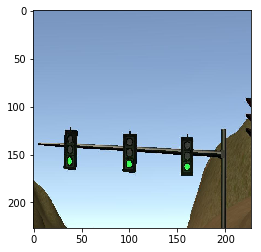

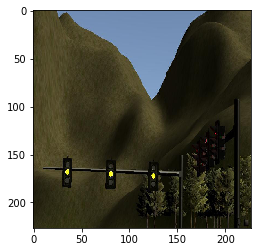

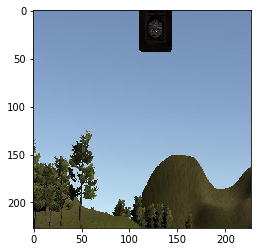

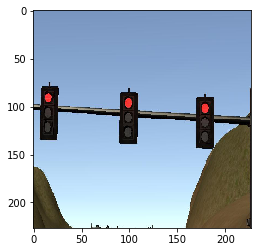

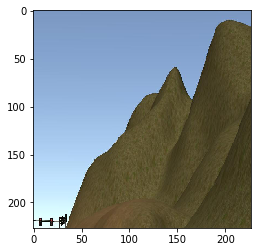

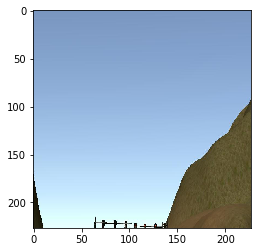

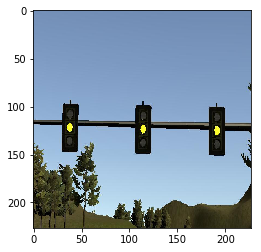

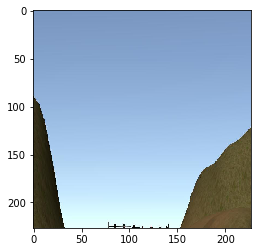

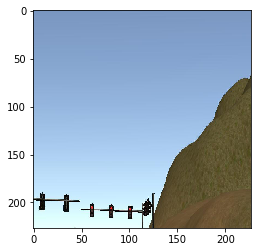

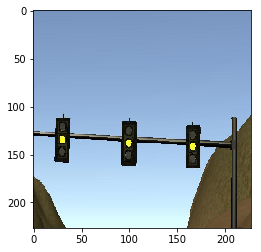

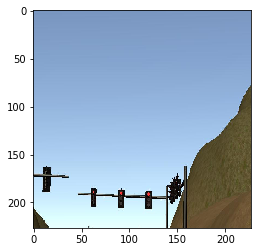

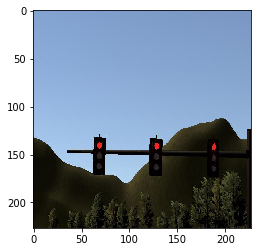

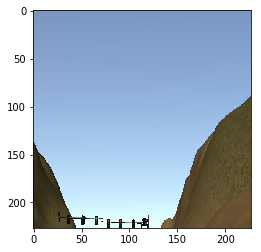

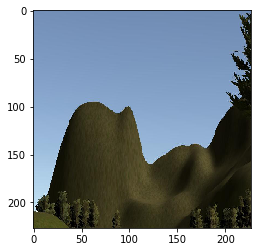

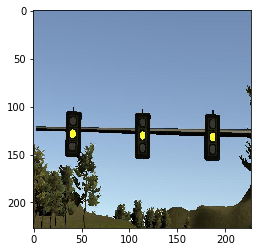

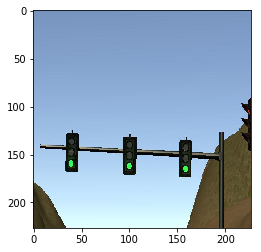

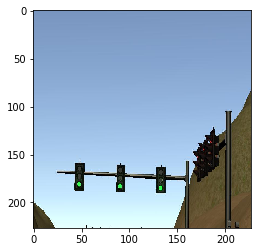

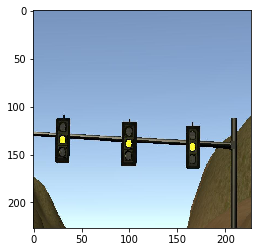

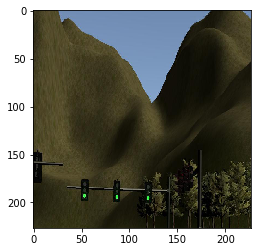

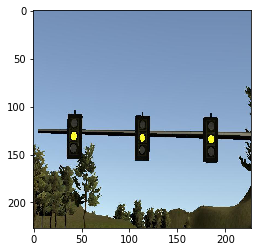

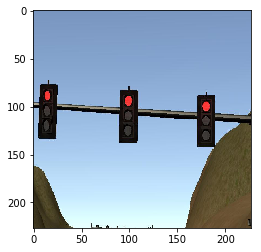

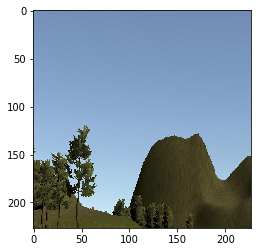

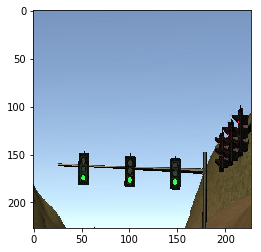

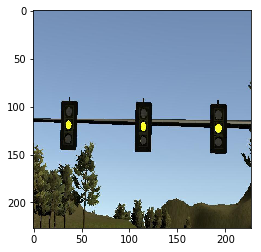

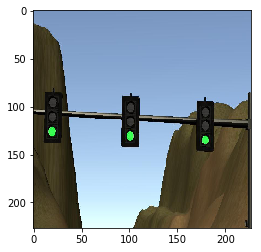

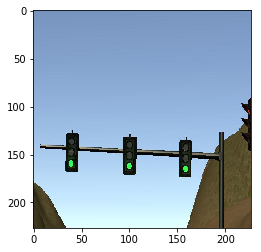

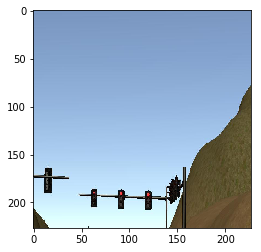

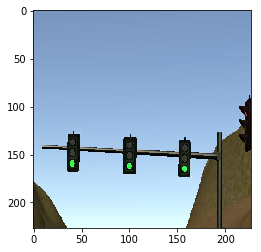

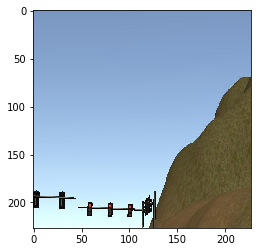

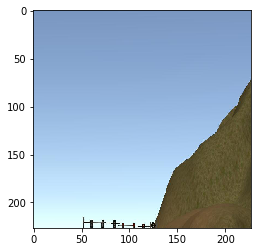

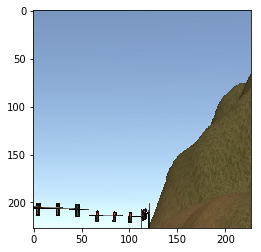

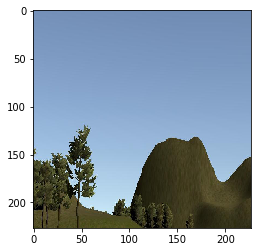

In [42]:
traffic_light_states = ['GREEN', 'RED', 'YELLOW', 'NO COLOR']


for i in range(len(images)):
    
    img = images[i]
    
    plt.figure()
    plt.imshow(img)

    prediction = model_final.predict(np.array([img]))[0]
    prediction_label = traffic_light_states[prediction.argmax()]

    print(prediction_label)